In [362]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython import display
import pylab as pl

In [363]:
def solver(dt,rho,c_p,k,r,dr,T,dtheta,h,T_f):
    # indices: [(i,j),(i-1,j),(i+1,j),(i,j-1),(i,j+1)]

    cond_1 = k[1]*(T[1]-T[0])/(dr**2)
    cond_2 = k[2]*(T[2]-T[0])/(dr**2)
    cond_3 = k[0]*(T[2]-T[1])/(2*r*dr)
    cond_4 = k[3]*(T[3]-T[0])/(r**2*dtheta**2)
    cond_5 = k[4]*(T[4]-T[0])/(r**2*dtheta**2)

    #cond_radial = (k[2]*(r+dr)*(T[2]-T[0]) + k[1]*(r-dr)*(T[1]-T[0])) / (r*dr**2)
    #cond_angular = (k[4]*(r)*(T[4]-T[0]) + k[3]*(r)*(T[3]-T[0])) / (r**2*dtheta**2)

    #conduction = dt/(rho[0]*c_p[0])*((k[2]*(r+dr)*(T[2]-T[0])/dr-k[1]*(r-dr)*(T[0]-T[1]))/(r*dr)+(k[4]*(r+dr)*(T[4]-T[0])/dtheta-k[3]*(r-dr)*(T[0]-T[3])/dtheta)/(dtheta*r**2))
    if h != 0:
        convection = h*(T_f-T[0])/(rho[0]*c_p[0]*dr)
    else:
        convection = 0
    
    T_new = dt/(rho[0]*c_p[0]) * (cond_1 + cond_2 + cond_3 + cond_4 + cond_5 + convection) + T[0]
    return T_new

In [364]:
# Geometry

# Radius in [m]
r_i = 0.006
r_interface = 0.008
r_o = 0.010

# Angle in [rad]
theta_0 = 0
theta_1 = np.pi/3

# Grid size
dr = 0.0004
dr2 = dr**2
r = np.arange(r_i,r_o,dr)
r = np.append(r,r_o)
n_r = len(r)
print(n_r)
ind_interface = (np.abs(r-r_interface)).argmin()

dtheta = np.pi/30
dtheta2 = dtheta**2
theta = np.arange(theta_0,theta_1,dtheta)
theta = np.append(theta,theta_1)
n_theta = len(theta)
print(n_theta)

# Time steps
t = 0
dt = 0.00000001

# Thermal properties
# k = [W/m-K]
# rho = [kg/m^3]
# c_p = [J/kg-k]

# Alumina properties
k_i = 30
rho_i = 3900
c_p_i = 500

# Graphite properties
k_o = 400
rho_o = 2250
c_p_o = 707

# Alumina properties
k_i = 1
rho_i = 1
c_p_i = 1

# Graphite properties
k_o = 1
rho_o = 1
c_p_o = 1

# Convection properties
k = 30
mdot = 150*0.00129/60
mu = 1.81e-5
c_p = 1005
d = 0.00730
h = k*d*0.023*(mdot*d/mu)**0.8*(mu*c_p/k)**0.4 * 100
print(h)
T_f = 25

# Constant temperature properties
T_const = 300

T_old = np.ones((n_r,n_theta))*T_const
T_new = T_old
d2 = [0,dr2,dr2,dtheta2,dtheta2]
d = [0,dr,dr,dtheta,dtheta]

k_avg = (k_i+k_o)/2
rho_avg = (rho_i+rho_o)/2
c_p_avg = (c_p_i+c_p_o)/2

residual = [np.NaN]
n = 0
t = [0]

dtmax = (dr**2 + dtheta**2)/(2*k_o)
print(dtmax)

11
11
0.03210705758758255
0.0054831935561607545


In [365]:
thresh = 1
for ind in range(100000):
#while (residual[n] > thresh or n==0):
    n = n + 1
    t.append(t[n-1]+dt)

    # Save previous iteration
    T_old = T_new
    # Initialize new iteration as ones (could be anything, it gets overwritten)
    T_new = np.ones((n_r,n_theta))

    # Set constant temperature at outer radius
    T_new[n_r-1,int(n_theta/2):n_theta] = T_const

    # Material properties for outer region
    rho_outer = [rho_o,rho_o,rho_o,rho_o,rho_o]
    c_p_outer = [c_p_o,c_p_o,c_p_o,c_p_o,c_p_o]
    k_outer = [k_o,k_o,k_o,k_o,k_o]

    # Material properties for interface region
    rho_interface = [rho_avg,rho_i,rho_o,rho_avg,rho_avg]
    c_p_interface = [c_p_avg,c_p_i,c_p_o,c_p_avg,c_p_avg]
    k_interface = [k_avg,k_i,k_o,k_avg,k_avg]

    # Material properties for inner region
    rho_inner = [rho_i,rho_i,rho_i,rho_i,rho_i]
    c_p_inner = [c_p_i,c_p_i,c_p_i,c_p_i,c_p_i]
    k_inner = [k_i,k_i,k_i,k_i,k_i]

    # Step through domain by radius, starting at outer radius and going inward
    for i in range(n_r-1,-1,-1):
        # Solve temperature at adiabatic surface on outer radius
        if i == n_r-1:
            # Left point
            T_local = [T_old[i,0],T_old[i-1,0],T_old[i-1,0],T_old[i,1],T_old[i,1]]
            T_new[i,0] = solver(dt,rho_outer,c_p_outer,k_outer,r[i],dr,T_local,dtheta,0,T_f)
            # Outer radius (adiabatic in radial direction)
            for j in range(1,int(n_theta/2)):
                T_local = [T_old[i,j],T_old[i-1,j],T_old[i-1,j],T_old[i,j-1],T_old[i,j+1]]
                T_new[i,j] = solver(dt,rho_outer,c_p_outer,k_outer,r[i],dr,T_local,dtheta,0,T_f)

        # Material outside of interface
        if (i>ind_interface) and (i<n_r-1):
            # Left point
            T_local = [T_old[i,0],T_old[i-1,0],T_old[i+1,0],T_old[i,1],T_old[i,1]]
            T_new[i,0] = solver(dt,rho_outer,c_p_outer,k_outer,r[i],dr,T_local,dtheta,0,T_f)
            # Right point
            T_local = [T_old[i,n_theta-1],T_old[i-1,n_theta-1],T_old[i+1,n_theta-1],T_old[i,n_theta-2],T_old[i,n_theta-2]]
            T_new[i,n_theta-1] = solver(dt,rho_outer,c_p_outer,k_outer,r[i],dr,T_local,dtheta,0,T_f)
            # Inner points
            for j in range(1,n_theta-1):
                T_local = [T_old[i,j],T_old[i-1,j],T_old[i+1,j],T_old[i,j-1],T_old[i,j+1]]
                T_new[i,j] = solver(dt,rho_outer,c_p_outer,k_outer,r[i],dr,T_local,dtheta,0,T_f)

        # Solve temperature at interface
        if (i == ind_interface):
            # Left point
            T_local = [T_old[i,0],T_old[i-1,0],T_old[i+1,0],T_old[i,1],T_old[i,1]]
            T_new[i,0] = solver(dt,rho_interface,c_p_interface,k_interface,r[i],dr,T_local,dtheta,0,T_f)
            # Right point
            T_local = [T_old[i,n_theta-1],T_old[i-1,n_theta-1],T_old[i+1,n_theta-1],T_old[i,n_theta-2],T_old[i,n_theta-2]]
            T_new[i,n_theta-1] = solver(dt,rho_interface,c_p_interface,k_interface,r[i],dr,T_local,dtheta,0,T_f)
            # Inner points
            for j in range(1,n_theta-1):
                T_local = [T_old[i,j],T_old[i-1,j],T_old[i+1,j],T_old[i,j-1],T_old[i,j+1]]
                T_new[i,j] = solver(dt,rho_interface,c_p_interface,k_interface,r[i],dr,T_local,dtheta,0,T_f)

        # Material inside of interface
        if (i < ind_interface) and (i>0):
            # Left point
            T_local = [T_old[i,0],T_old[i-1,0],T_old[i+1,0],T_old[i,1],T_old[i,1]]
            T_new[i,0] = solver(dt,rho_inner,c_p_inner,k_inner,r[i],dr,T_local,dtheta,0,T_f)
            # Right point
            T_local = [T_old[i,n_theta-1],T_old[i-1,n_theta-1],T_old[i+1,n_theta-1],T_old[i,n_theta-2],T_old[i,n_theta-2]]
            T_new[i,n_theta-1] = solver(dt,rho_inner,c_p_inner,k_inner,r[i],dr,T_local,dtheta,0,T_f)
            # Inner points
            for j in range(1,n_theta-1):
                T_local = [T_old[i,j],T_old[i-1,j],T_old[i+1,j],T_old[i,j-1],T_old[i,j+1]]
                T_new[i,j] = solver(dt,rho_inner,c_p_inner,k_inner,r[i],dr,T_local,dtheta,0,T_f)
        
        # Convection boundary
        if (i == 0):
            # Left point
            T_local = [T_old[0,0],T_old[1,0],T_old[1,0],T_old[0,1],T_old[0,1]]
            T_new[0,0] = solver(dt,rho_inner,c_p_inner,k_inner,r[i],dr,T_local,dtheta,h,T_f)
            # Right point
            T_local = [T_old[0,n_theta-1],T_old[1,n_theta-1],T_old[1,n_theta-1],T_old[0,n_theta-2],T_old[0,n_theta-2]]
            T_new[0,n_theta-1] = solver(dt,rho_inner,c_p_inner,k_inner,r[i],dr,T_local,dtheta,h,T_f)
            # Inner radius (adiabatic in radial direction)
            for j in range(1,n_theta-1):
                T_local = [T_old[0,j],T_old[1,j],T_old[1,j],T_old[0,j-1],T_old[0,j+1]]
                T_new[0,j] = solver(dt,rho_inner,c_p_inner,k_inner,r[i],dr,T_local,dtheta,h,T_f)
    
    residual.append(np.linalg.norm(T_new)-np.linalg.norm(T_old))

<ipython-input-367-0a19acf8d432>:26: RuntimeWarning: divide by zero encountered in log
  convergence_rate.append(np.log(np.abs(residual[i])/np.abs(residual[i-1]))/np.log(dt))
<ipython-input-367-0a19acf8d432>:26: RuntimeWarning: divide by zero encountered in double_scalars
  convergence_rate.append(np.log(np.abs(residual[i])/np.abs(residual[i-1]))/np.log(dt))
<ipython-input-367-0a19acf8d432>:26: RuntimeWarning: invalid value encountered in double_scalars
  convergence_rate.append(np.log(np.abs(residual[i])/np.abs(residual[i-1]))/np.log(dt))


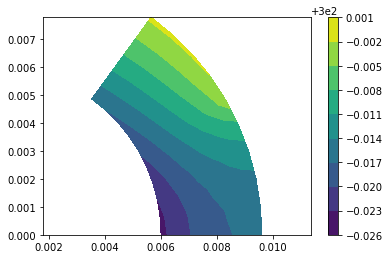

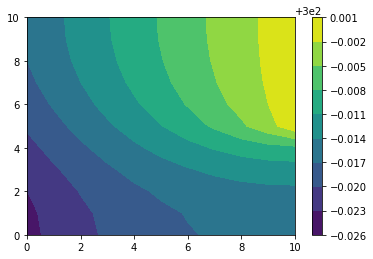

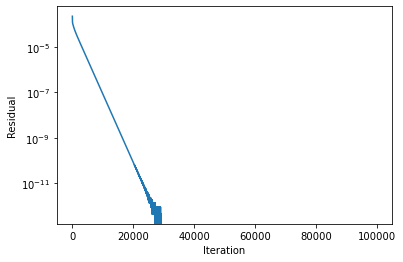

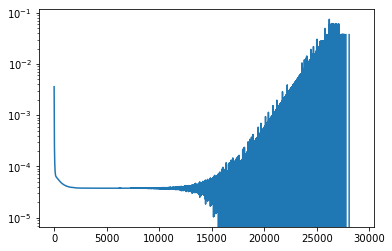

In [367]:
fig,ax = plt.subplots()
x = np.zeros((n_r-1,n_theta-1))
y = np.zeros((n_r-1,n_theta-1))
for i in range(n_r-1):
    for j in range(n_theta-1):
        x[i,j] = r[i]*np.cos(theta[j])
        y[i,j] = r[i]*np.sin(theta[j])
ax.axis('equal')
cf = plt.contourf(x,y,T_new[0:n_r-1,0:n_theta-1])
cbar = plt.colorbar(cf)

fig = plt.subplots()
x = np.arange(0,n_r)
y = np.arange(0,n_theta)
X,Y = np.meshgrid(x,y)
cf = plt.contourf(X,Y,np.transpose(T_new))
plt.colorbar()

fig = plt.subplots()
plt.semilogy(np.arange(n+1),np.abs(residual))
plt.xlabel("Iteration")
plt.ylabel("Residual")

convergence_rate = []
for i in np.arange(1,len(residual),dtype=int):
    convergence_rate.append(np.log(np.abs(residual[i])/np.abs(residual[i-1]))/np.log(dt))

fig = plt.subplots()
plt.semilogy(np.arange(n),convergence_rate)